# GANs In Action
## Chapter 2: Autoencoder
This is the accompanying code for the upcoming book _GANs in Action Deep Learning with Generative Adversarial Networks (GANs)_ by Manning Books. 

This tutorial was adapted from the [following tutorial](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py), which was published under MIT license.

## Why Colab?
Google Colabotary is an amazing way to run [Jupyter notebooks](http://jupyter.org) online, sprinkled on top with some Google goodness. We chose this environment, because it is compatible with the industry standard Jupyter notebooks but can be run by anyone with zero setup. But you are free to switch between the two commands as required.

## Why autoencoders? 
Well for that you'd need to buy the book ;) 

## Let's get started! 
And the only way to get started is with imports!

For reference, this code was checked with Keras as late as `2.2.4` and Tensorflow as late as `1.12.0`.

In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Next let's define some key variables.
We explain their meaning more in Chapter 2.

In [0]:
# defining the key parameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## Define sampling helper function. 

As per [PEP484](https://www.python.org/dev/peps/pep-0484/) we define typehints for this function. 

Args have to be a tuple, because we ultimately want to use this as a [Lambda function](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) or also called "Annoymous functions", but you didn't hear that from me ;) 

Remember that Lambda defines yet another function so we basically just defined two functions in the code below.

The implementation that follows is inspired by Branko Blagojevic in our book forums. [Thank you for this suggestion](https://forums.manning.com/posts/list/45083.page).

In [0]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Defining the encoder

In [5]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

# Defining the decoder

In [6]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## Now let's define the Variational Autoencoder (VAE)
We use the encoder and decoder objects names from above. 


In [7]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## Colab hints
In the same way as with Jupyter notebook, we can ask for help if we do not know an object and it shows us the doc string. In case this was a suprise, or would like to know more about Colab, everyone gets "Intro to Colab" automatically into their GDrive when they start using Colab.

In [0]:
Model??

## Read the doc string!
We find out that Model inherits from `Container` and is the way that Keras likes to thing of a fully parametrized model, similar to [sklearn](http://scikit-learn.org/stable/index.html) that gives you loads of useful methods that you can read about in the doc string. For data scientists, this should put you into well understood territory.

## Define the losses and run the model!
We touch on [KL loss](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) (`xent_loss`) throughout the book, but these do not need to be familiar terms, as long as you understand the notion of a loss in machine learning.

In [9]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## Let's take a look at the Keras' representation of the model
We can see above that the model has roughly the structure we expect:

784-> `latent_dim` -> 2 Gaussian parameters -> `latent_dim` -> 768.

Plus some extra things on top.

## It would not be Data Science, without _data_.
Let's load and clean the only dataset there is, apparently: MNIST.


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
60000/60000 [==============================] - 18s 305us/step - loss: 188.2754
Epoch 2/50
60000/60000 [==============================] - 18s 302us/step - loss: 169.3124
Epoch 3/50
60000/60000 [==============================] - 18s 306us/step - loss: 165.8300
Epoch 4/50
60000/60000 [==============================] - 18s 304us/step - loss: 163.5297
Epoch 5/50
60000/60000 [==============================] - 18s 304us/step - loss: 161.7262
Epoch 6/50
60000/60000 [==============================] - 18s 302us/step - loss: 160.2289
Epoch 7/50
60000/60000 [==============================] - 18s 305us/step - loss: 159.0346
Epoch 8/50
60000/60000 [==============================] - 18s 304us/step - loss: 158.0955
Epoch 9/50
60000/60000 [==============================] - 18s 304us/step - loss: 157.3553
Epoch 10/50
60000/60000 [==============================] - 18s 304us/step - loss: 156.7196
Epoch 11/50
60000/60000 [==============================] - 18s 305us/step - loss: 156.2162
Epoch 12

## Next we grab just the "data-generating" part of the model. 
In the book we explained how we generate the new images in Figure 2.3.

We will now generate the Figure in 2.6. 

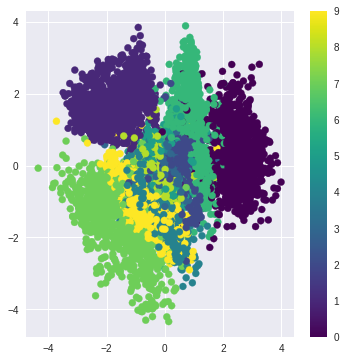

In [12]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Last but not least, let's generate Figure 2.7.

The only tricky part here is that we have to create a grid over which we interpolate. Which we do by using `np.linspace`, which enables us to move between `min` and `max` value in `step_size`. 

We then just generate a digit for each sample in the for loop and display!

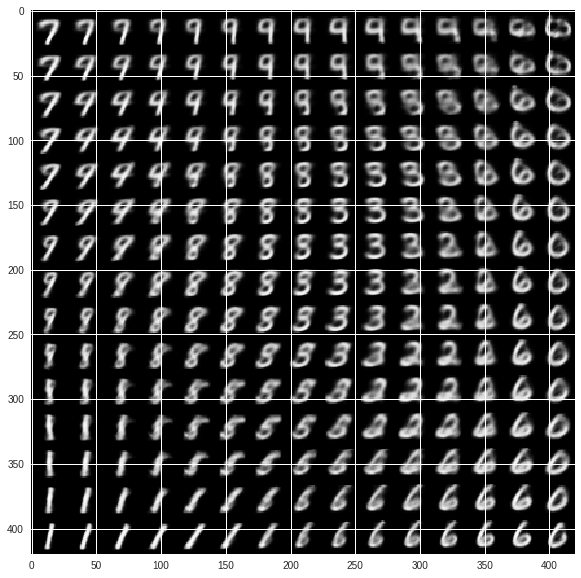

In [13]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()